In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
artists=pd.read_csv('../datasets/artists.csv')

G_geo_B_filtered_one = nx.read_gexf('gexf/G_geo_B_filtered_one_mod.gexf')

Node attributes (we need to use birth_year_order_1_to_N to create graphs, for the links we need movement too)

In [3]:
set([k for n in G_geo_B_filtered_one.nodes for k in G_geo_B_filtered_one.nodes[n].keys()])

{'birth_year',
 'birth_year_order_1_to_N',
 'first_year',
 'label',
 'last_year',
 'movement'}

In [5]:
G_geo_B_filtered_one.nodes['Ad Reinhardt']

{'birth_year': 1913,
 'first_year': 1937,
 'last_year': 1966,
 'birth_year_order_1_to_N': 466,
 'movement': 'Abstract Expressionism',
 'label': 'Ad Reinhardt'}

In [4]:
#Last number:

np.max([int(G_geo_B_filtered_one.nodes[n]['birth_year_order_1_to_N']) for n in G_geo_B_filtered_one.nodes])

512

All nodes have a birth year, birth year order (1,2,3, ... , last), and movement

## Triangle closure

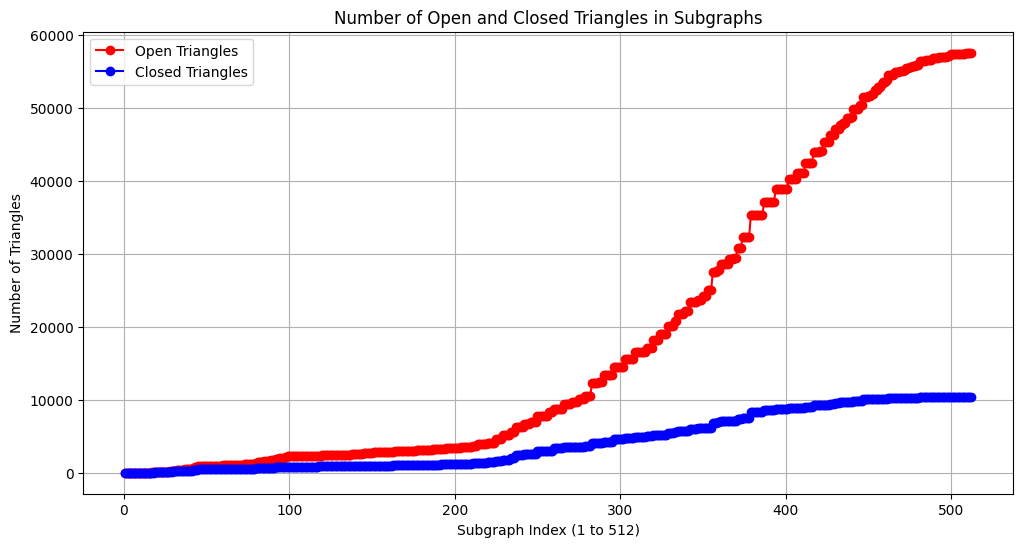

In [14]:
#For i in 1 to 512 (number of nodes):
#Create a graph with nodes with attribute birth_year_order_1_to_N less or equal to i
#Measure the number of triangles in the graph, save this number in a list

open_triangle_counts = []
closed_triangle_counts = []

for i in range(1, 513):
    #Subgraph
    subgraph_nodes = [node for node, attrs in G_geo_B_filtered_one.nodes(data=True) if attrs.get('birth_year_order_1_to_N', 0) <= i]
    subgraph = G_geo_B_filtered_one.subgraph(subgraph_nodes)

    #Closed triangles (all three edges are present)
    closed_triangles = sum(nx.triangles(subgraph).values()) // 3

    #Open triangles (two edges with a missing third edge)
    open_triangles = 0
    for node in subgraph:
        neighbors = set(nx.neighbors(subgraph, node))
        for neighbor1 in neighbors:
            for neighbor2 in neighbors:
                if neighbor1 != neighbor2 and not subgraph.has_edge(neighbor1, neighbor2):
                    open_triangles += 1
    open_triangles //= 3  # Each open triangle is counted three times

    open_triangle_counts.append(open_triangles)
    closed_triangle_counts.append(closed_triangles)

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(range(1, 513), open_triangle_counts, marker='o', color='red', label='Open Triangles')
plt.plot(range(1, 513), closed_triangle_counts, marker='o', color='blue', label='Closed Triangles')
plt.title('Number of Open and Closed Triangles in Subgraphs')
plt.xlabel('Subgraph Index (1 to 512)')
plt.ylabel('Number of Triangles')
plt.grid(True)
plt.legend()
plt.show()


In [16]:
sum(nx.triangles(G_geo_B_filtered_one).values()) // 3

10406

### Ratio of open to closed triangles

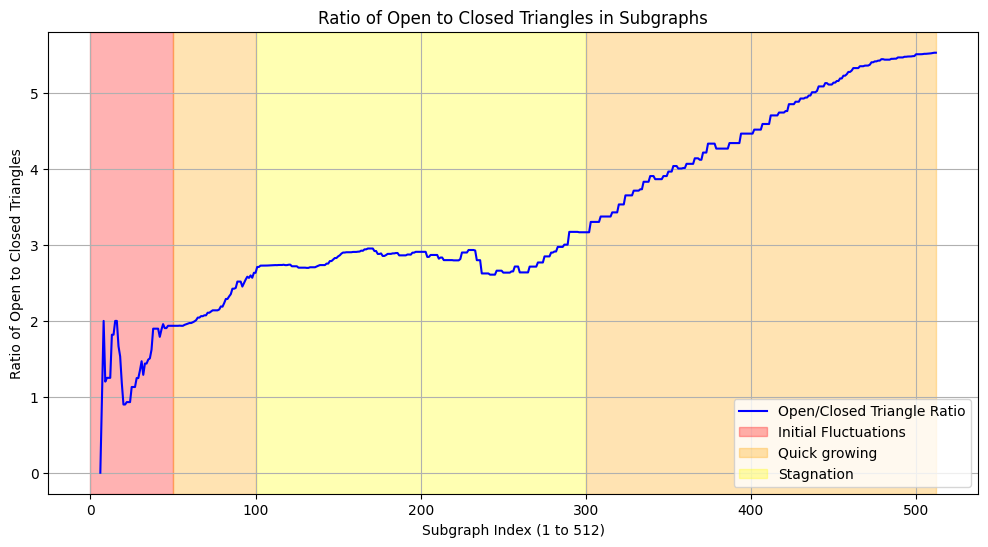

In [20]:
# Calculate the ratio of open to closed triangles and plot it
ratios = [open_t / closed_t if closed_t > 0 else float('inf') for open_t, closed_t in zip(open_triangle_counts, closed_triangle_counts)]

plt.figure(figsize=(12, 6))
plt.plot(range(1, 513), ratios, color='blue', label='Open/Closed Triangle Ratio')
plt.title('Ratio of Open to Closed Triangles in Subgraphs')
# Annotate periods on the plot
plt.axvspan(0, 50, color='red', alpha=0.3, label='Initial Fluctuations')
plt.axvspan(50, 100, color='orange', alpha=0.3, label='Quick growing')
plt.axvspan(100, 300, color='yellow', alpha=0.3, label='Stagnation')
plt.axvspan(300, 512, color='orange', alpha=0.3)
plt.xlabel('Subgraph Index (1 to 512)')
plt.ylabel('Ratio of Open to Closed Triangles')
plt.grid(True)
plt.legend()
plt.show()


#### Expected ratio of open to closed triangles in a random graph of the same size

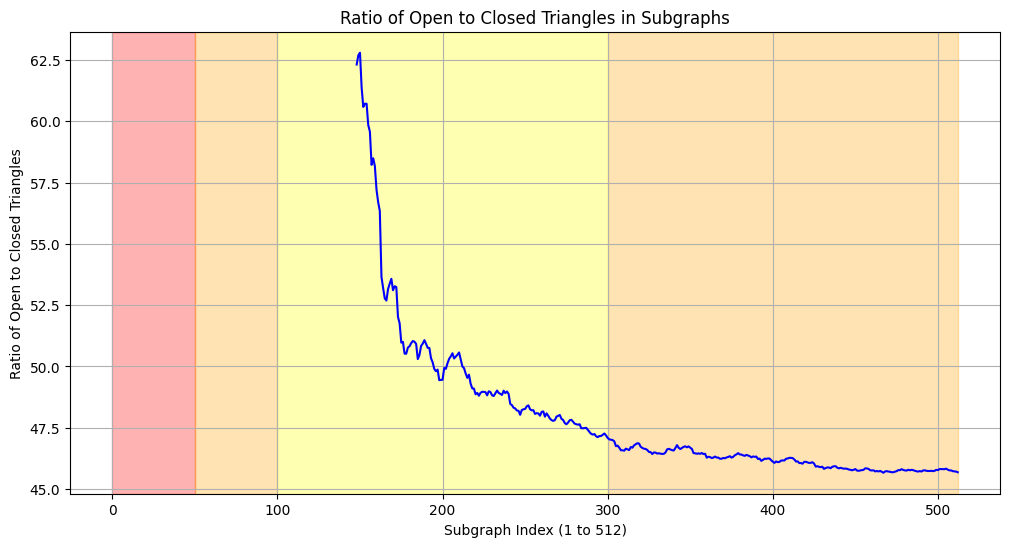

In [53]:
import itertools
import numpy as np

#Random graph attributes
n = 512
edges = 2811
p = edges / (n * (n - 1) / 2)

#Generate 100 random graphs and average the number of triangles
random_graphs = []
for i in range(100):
    random_graph = nx.erdos_renyi_graph(n, p)
    random_graphs.append(random_graph)

turn = 0
ratios = np.array([])

for random_graph in random_graphs:
    # Initialize lists to store the count of open and closed triangles for the random graph
    open_triangle_counts_random = []
    closed_triangle_counts_random = []
    turn += 1

    # Identifying open and closed triangles for the random graph
    for i in range(1, n + 1):
        # Creating a subgraph with nodes less or equal to i
        subgraph = random_graph.subgraph(range(i))

        # Counting closed triangles
        closed_triangles = sum(nx.triangles(subgraph).values()) // 3

        # Counting open triangles
        open_triangles = 0
        for node in subgraph:
            neighbors = set(nx.neighbors(subgraph, node))
            for neighbor1, neighbor2 in itertools.combinations(neighbors, 2):
                if not subgraph.has_edge(neighbor1, neighbor2):
                    open_triangles += 1
        open_triangles //= 3  # Each open triangle is counted three times

        # Append counts to respective lists
        open_triangle_counts_random.append(open_triangles)
        closed_triangle_counts_random.append(closed_triangles)

    # Calculate the ratio of open to closed triangles for the random graph
    ratios_random = [open_t / closed_t if closed_t > 0 else float('inf') for open_t, closed_t in zip(open_triangle_counts_random, closed_triangle_counts_random)]
    ratios_random = np.array(ratios_random)
    if turn == 1:
        ratios = ratios_random
    else: #Average the ratios
        ratios = (ratios*turn + ratios_random)/(turn+1)




# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(range(1, 513), ratios, color='blue', label='Open/Closed Triangle Ratio')
plt.title('Ratio of Open to Closed Triangles in Subgraphs')
# Annotate periods on the plot
plt.axvspan(0, 50, color='red', alpha=0.3, label='Initial Fluctuations')
plt.axvspan(50, 100, color='orange', alpha=0.3, label='Quick growing')
plt.axvspan(100, 300, color='yellow', alpha=0.3, label='Stagnation')
plt.axvspan(300, 512, color='orange', alpha=0.3)
plt.xlabel('Subgraph Index (1 to 512)')
plt.ylabel('Ratio of Open to Closed Triangles')
plt.grid(True)

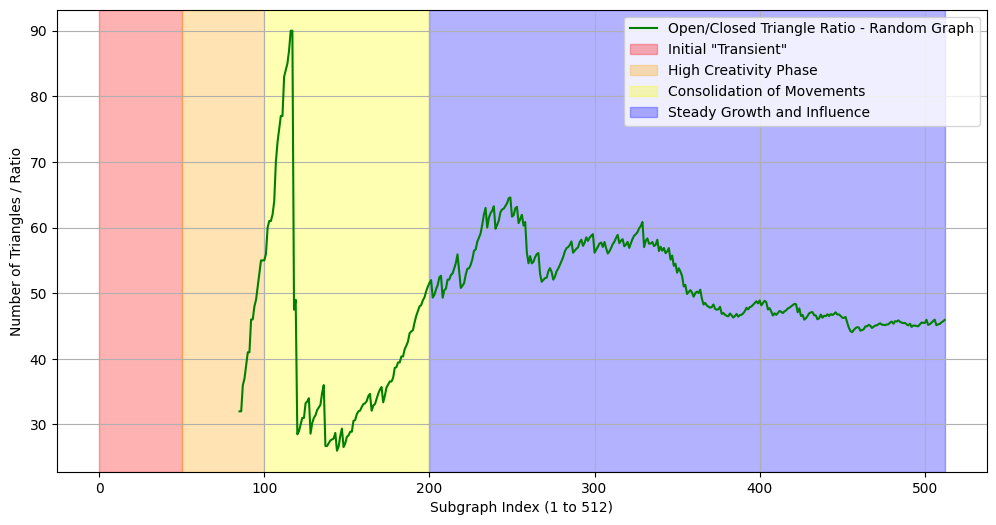

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, n+1), ratios_random, color='green', label='Open/Closed Triangle Ratio - Random Graph')
# Annotate periods on the plot
plt.axvspan(0, 50, color='red', alpha=0.3, label='Initial "Transient"')
plt.axvspan(50, 100, color='orange', alpha=0.3, label='High Creativity Phase')
plt.axvspan(100, 200, color='yellow', alpha=0.3, label='Consolidation of Movements')
plt.axvspan(200, n, color='blue', alpha=0.3, label='Steady Growth and Influence')
plt.xlabel('Subgraph Index (1 to 512)')
plt.ylabel('Number of Triangles / Ratio')
plt.grid(True)
plt.legend()
plt.show()

## Time-periods

In [15]:
[attrs['birth_year'] for node, attrs in G_geo_B_filtered_one.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 1][0]

1255

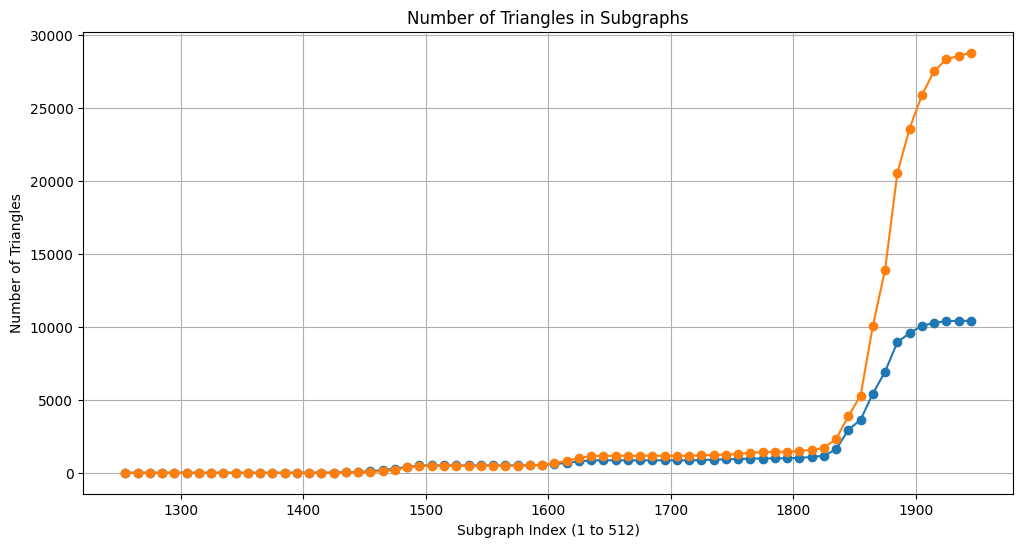

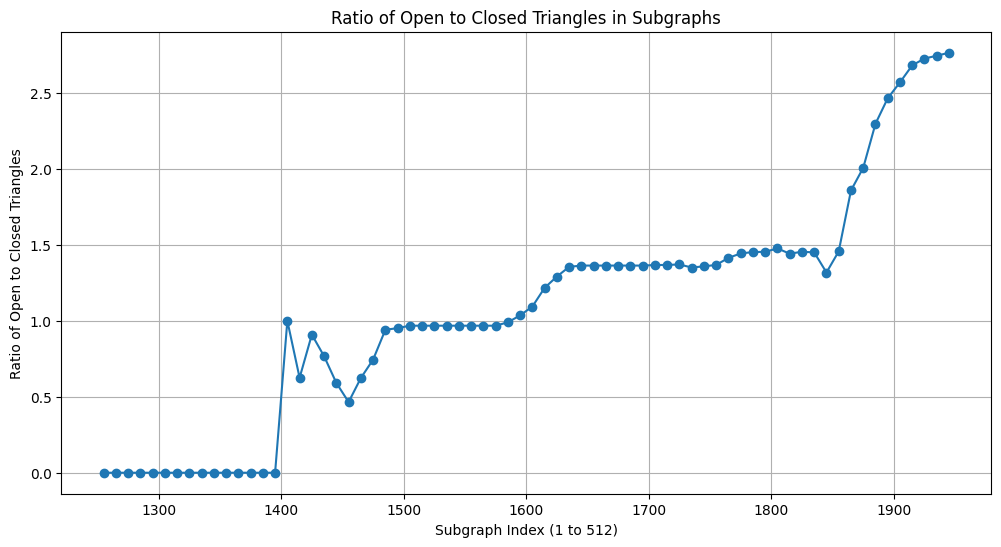

In [30]:
#Triangle closure, but not by birth year order, but by 10 year intervals

# Initializing a list to store the number of triangles for each graph
closed_triangle_counts = []
open_triangle_counts = [] # 3 nodes with 2 edges between them
ratio_counts = []
min_year = [attrs['birth_year'] for node, attrs in G_geo_B_filtered_one.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 1][0]
max_year = [attrs['birth_year'] for node, attrs in G_geo_B_filtered_one.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 512][0]

# Iterating through the nodes to create subgraphs and count triangles
for i in range(min_year, max_year+1, 10):
    # Creating a subgraph with nodes having 'birth_year_order_1_to_N' less or equal to i
    subgraph_nodes = [node for node, attrs in G_geo_B_filtered_one.nodes(data=True) if attrs['birth_year'] <= i]
    subgraph = G_geo_B_filtered_one.subgraph(subgraph_nodes)

    # Counting the number of triangles in the subgraph
    closed_triangles = sum(nx.triangles(subgraph).values()) // 3  # Each triangle is counted three times
    closed_triangle_counts.append(closed_triangles)
    # Counting the number of open triangles in the subgraph: 3 nodes with 2 edges between them
    open_triangles = 0
    for node in subgraph:
        neighbors = set(nx.neighbors(subgraph, node))
        for neighbor1, neighbor2 in itertools.combinations(neighbors, 2):
            if not subgraph.has_edge(neighbor1, neighbor2):
                open_triangles += 1
    open_triangles //= 3  # Each open triangle is counted three times
    open_triangle_counts.append(open_triangles)
    if closed_triangles > 0:
        ratio_counts.append(open_triangles/closed_triangles)
    else:
        ratio_counts.append(0)
    
    

# Visualizing the number of triangles for each subgraph

plt.figure(figsize=(12, 6))
plt.plot(range(min_year, max_year+1,10), closed_triangle_counts, marker='o')
plt.plot(range(min_year, max_year+1,10), open_triangle_counts, marker='o')
plt.title('Number of Triangles in Subgraphs')
plt.xlabel('Subgraph Index (1 to 512)')
plt.ylabel('Number of Triangles')
plt.grid(True)
plt.show()

# Visualizing the ratio of open to closed triangles for each subgraph

plt.figure(figsize=(12, 6))
plt.plot(range(min_year, max_year+1,10), ratio_counts, marker='o')
plt.title('Ratio of Open to Closed Triangles in Subgraphs')
plt.xlabel('Subgraph Index (1 to 512)')
plt.ylabel('Ratio of Open to Closed Triangles')
plt.grid(True)
plt.show()

# Cultural dynamics: <br>
Check how many links connect nodes with the same movement (intra-movement links) and nodes with different movements (inter-movement links)

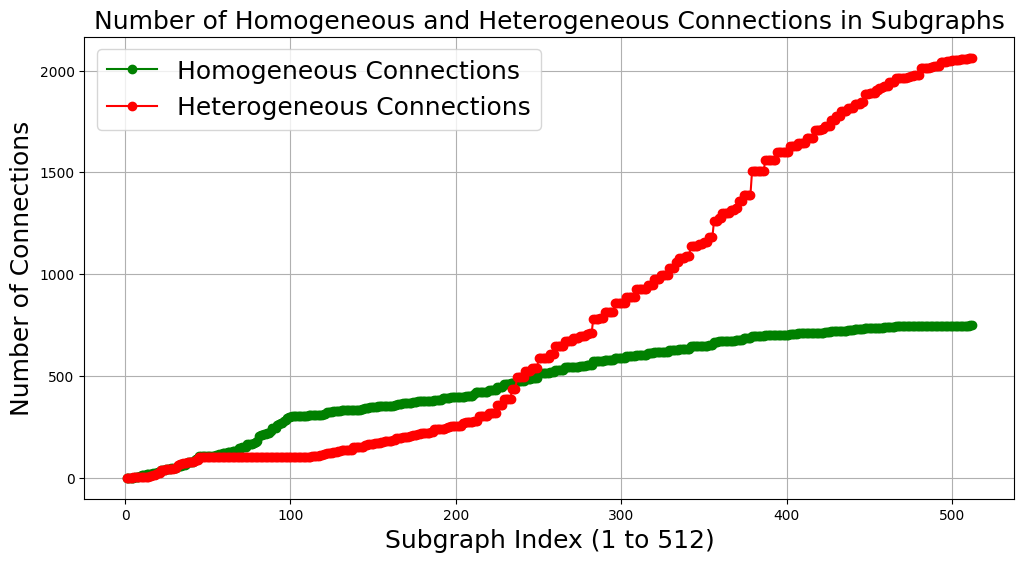

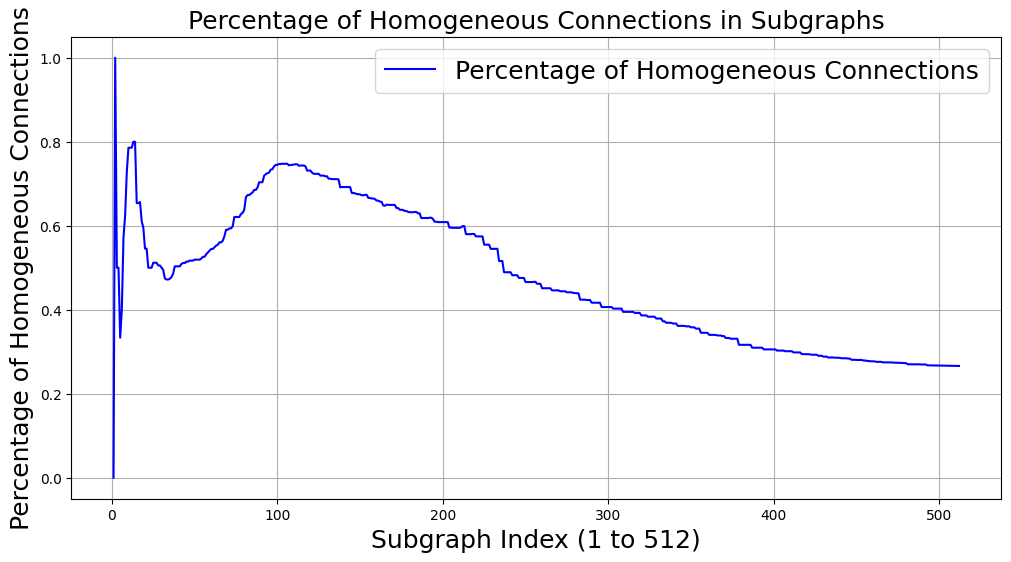

In [33]:
# Initialize lists to store the counts
good_connection_counts = []
bad_connection_counts = []
good_to_total_ratio = []
G = G_geo_B_filtered_one


# Iterate through the nodes to create subgraphs
for i in range(1, 513):
    # Create a subgraph
    subgraph_nodes = [node for node, attrs in G.nodes(data=True) if attrs['birth_year_order_1_to_N'] <= i]
    subgraph = G.subgraph(subgraph_nodes)

    # Count good and bad connections in the subgraph
    good_count = 0
    bad_count = 0
    for node1, node2 in subgraph.edges():
        movement1 = subgraph.nodes[node1].get('movement', None)
        movement2 = subgraph.nodes[node2].get('movement', None)
        if movement1 and movement2:
            if movement1 == movement2:
                good_count += 1
            else:
                bad_count += 1

    # Add the counts to the respective lists
    good_connection_counts.append(good_count)
    bad_connection_counts.append(bad_count)
    if good_count + bad_count > 0:
        good_to_total_ratio.append(good_count / (good_count + bad_count))
    else:
        good_to_total_ratio.append(0)

# Visualizing the counts
plt.figure(figsize=(12, 6))
plt.plot(range(1, 513), good_connection_counts, marker='o', color='green', label='Homogeneous Connections')
plt.plot(range(1, 513), bad_connection_counts, marker='o', color='red', label='Heterogeneous Connections')
plt.title('Number of Homogeneous and Heterogeneous Connections in Subgraphs', fontsize = 18)
plt.xlabel('Subgraph Index (1 to 512)', fontsize = 18)
plt.ylabel('Number of Connections', fontsize = 18)
plt.legend(fontsize = 18)
plt.grid(True)
plt.show()

# Visualizing the ratio in a separate graph
plt.figure(figsize=(12, 6))
plt.plot(range(1, 513), good_to_total_ratio, color='blue', label='Percentage of Homogeneous Connections')
plt.title('Percentage of Homogeneous Connections in Subgraphs', fontsize = 18)
plt.xlabel('Subgraph Index (1 to 512)', fontsize = 18)
plt.ylabel('Percentage of Homogeneous Connections', fontsize = 18)
plt.legend(fontsize = 18)
plt.grid(True)
plt.show()


## Time-periods

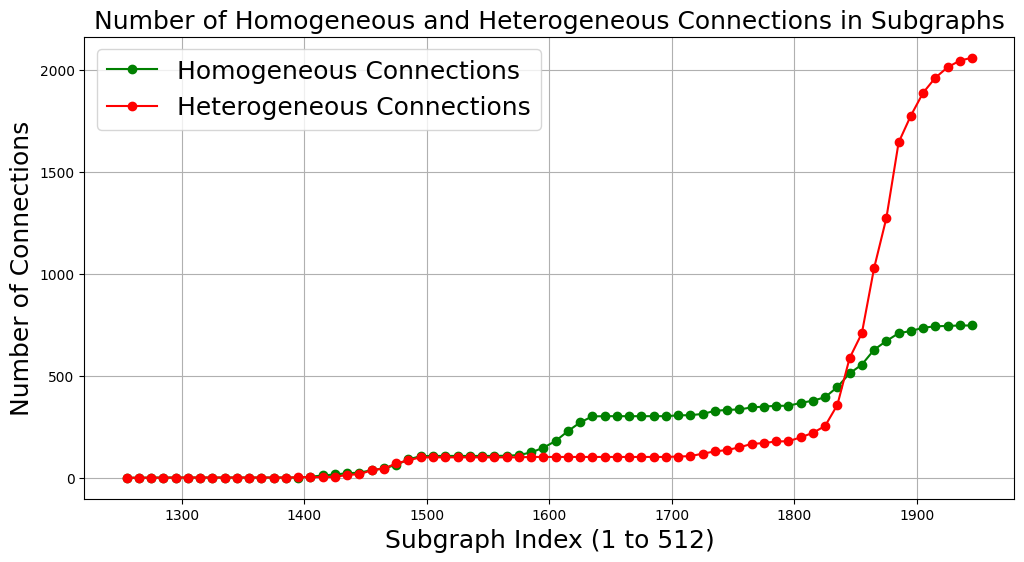

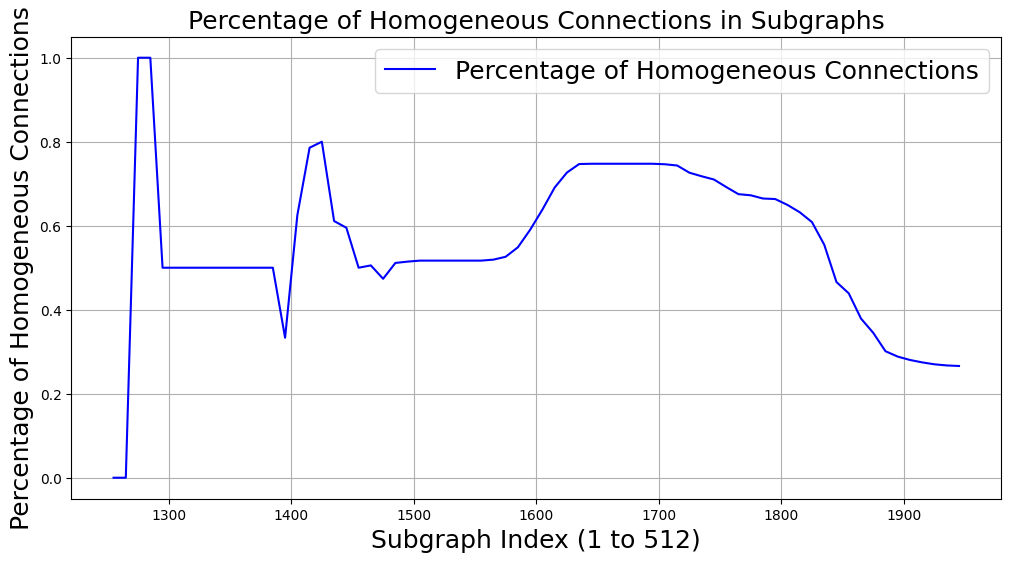

In [36]:
# Initialize lists to store the counts
good_connection_counts = []
bad_connection_counts = []
good_to_total_ratio = []
G = G_geo_B_filtered_one
min_year = [attrs['birth_year'] for node, attrs in G.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 1][0]
max_year = [attrs['birth_year'] for node, attrs in G.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 512][0]



# Iterate through the nodes to create subgraphs
for i in range(min_year, max_year+1, 10):
    # Create a subgraph
    subgraph_nodes = [node for node, attrs in G.nodes(data=True) if attrs['birth_year'] <= i]
    subgraph = G.subgraph(subgraph_nodes)

    # Count good and bad connections in the subgraph
    good_count = 0
    bad_count = 0
    for node1, node2 in subgraph.edges():
        movement1 = subgraph.nodes[node1].get('movement', None)
        movement2 = subgraph.nodes[node2].get('movement', None)
        if movement1 and movement2:
            if movement1 == movement2:
                good_count += 1
            else:
                bad_count += 1

    # Add the counts to the respective lists
    good_connection_counts.append(good_count)
    bad_connection_counts.append(bad_count)
    if good_count + bad_count > 0:
        good_to_total_ratio.append(good_count / (good_count + bad_count))
    else:
        good_to_total_ratio.append(0)

# Visualizing the counts
plt.figure(figsize=(12, 6))
plt.plot(range(min_year, max_year+1, 10), good_connection_counts, marker='o', color='green', label='Homogeneous Connections')
plt.plot(range(min_year, max_year+1, 10), bad_connection_counts, marker='o', color='red', label='Heterogeneous Connections')
plt.title('Number of Homogeneous and Heterogeneous Connections in Subgraphs', fontsize = 18)
plt.xlabel('Subgraph Index (1 to 512)', fontsize = 18)
plt.ylabel('Number of Connections', fontsize = 18)
plt.legend(fontsize = 18)
plt.grid(True)
plt.show()

# Visualizing the ratio in a separate graph
plt.figure(figsize=(12, 6))
plt.plot(range(min_year, max_year+1, 10), good_to_total_ratio, color='blue', label='Percentage of Homogeneous Connections')
plt.title('Percentage of Homogeneous Connections in Subgraphs', fontsize = 18)
plt.xlabel('Subgraph Index (1 to 512)', fontsize = 18)
plt.ylabel('Percentage of Homogeneous Connections', fontsize = 18)
plt.legend(fontsize = 18)
plt.grid(True)
plt.show()


In [70]:
#Get movement attribute counts

movement_counts = {}
for node, attrs in G_geo_B_filtered_one.nodes(data=True):
    movement = attrs.get('movement', None)
    if movement:
        movement_counts[movement] = movement_counts.get(movement, 0) + 1

movement_counts

{'Abstract Expressionism': 8,
 'Kinetic art': 1,
 'Abstract Art': 23,
 'Dada': 5,
 'Post-Impressionism': 22,
 'Pop Art': 7,
 'Surrealism': 14,
 'Symbolism': 23,
 'Social Realism': 5,
 'Precisionism': 3,
 'Realism': 44,
 'Futurism': 4,
 'Cubism': 9,
 'Impressionism': 40,
 'Expressionism': 28,
 'Avant-garde': 5,
 'Existential Art': 1,
 'Art Nouveau': 7,
 'Neo-Impressionism': 6,
 'Tonalism': 3,
 'Magic Realism': 1,
 'Pictorialism': 4,
 'Post-Painterly Abstraction': 3,
 'Contemporary Realism': 2,
 'Neo-Dada': 2,
 'Conceptual Art': 3,
 'Minimalism': 7,
 'Arte Povera': 1,
 'Art Informel': 2,
 'New Image Painting': 1,
 'Modernism': 4,
 'Academic Art': 8,
 'Romanticism': 59,
 'Suprematism': 2,
 'Orientalism': 3,
 'Regionalism': 2,
 'Neoclassicism': 11,
 'Neo-Romanticism': 1,
 'Rococo': 25,
 'Arts and Crafts': 1,
 'Baroque': 61,
 'Northern Renaissance': 17,
 'Proto Renaissance': 2,
 'Gothic Art': 2,
 'Op Art': 1,
 'Post-Minimalism': 1,
 'Early Renaissance': 11,
 'High Renaissance': 17}

In [73]:
sum = 0
for tuple in movement_counts.items():
    sum += tuple[1]
sum

512

In [76]:
for node in random_graph.nodes():
    random_graph.nodes[node]['movement'] = np.random.choice(list(movement_counts.keys()), p=[count/sum for count in movement_counts.values()])
   

In [77]:
#List random graph movement counts

random_movement_counts = {}
for node, attrs in random_graph.nodes(data=True):
    movement = attrs.get('movement', None)
    if movement:
        random_movement_counts[movement] = random_movement_counts.get(movement, 0) + 1

random_movement_counts

{'Post-Impressionism': 26,
 'Impressionism': 42,
 'Realism': 46,
 'Academic Art': 13,
 'Romanticism': 65,
 'Neo-Dada': 3,
 'Expressionism': 28,
 'High Renaissance': 15,
 'Dada': 4,
 'Pictorialism': 4,
 'Baroque': 65,
 'Abstract Art': 21,
 'Gothic Art': 4,
 'Rococo': 30,
 'Pop Art': 7,
 'Surrealism': 11,
 'Northern Renaissance': 16,
 'Abstract Expressionism': 4,
 'Tonalism': 2,
 'Conceptual Art': 3,
 'Precisionism': 3,
 'Cubism': 11,
 'Symbolism': 24,
 'Op Art': 2,
 'Futurism': 5,
 'Social Realism': 5,
 'Regionalism': 2,
 'Art Nouveau': 7,
 'Minimalism': 8,
 'Neoclassicism': 5,
 'Neo-Impressionism': 10,
 'Contemporary Realism': 2,
 'Avant-garde': 1,
 'Modernism': 5,
 'Neo-Romanticism': 1,
 'Post-Painterly Abstraction': 2,
 'Post-Minimalism': 2,
 'Arts and Crafts': 2,
 'New Image Painting': 1,
 'Early Renaissance': 2,
 'Art Informel': 2,
 'Kinetic art': 1}

In [78]:
#Random graph of the same size

#Random graph attributes
n = 512
edges = 2811
p = edges / (n * (n - 1) / 2)

#Generate 100 random graphs and average the ratio of homogeneous connections
random_graphs = []
for i in range(100):
    random_graph = nx.erdos_renyi_graph(n, p)
    random_graphs.append(random_graph)

turn = 0
ratios = np.array([])
min_year = [attrs['birth_year'] for node, attrs in G.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 1][0]
max_year = [attrs['birth_year'] for node, attrs in G.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 512][0]

for random_graph in random_graphs:
    # Add random movement attribute to each node, proportional to the movement counts in the original graph
    for node in random_graph.nodes():
        random_graph.nodes[node]['movement'] = np.random.choice(list(movement_counts.keys()), p=[count/sum for count in movement_counts.values()])
    # Initialize lists to store the counts
    good_connection_counts = []
    bad_connection_counts = []
    good_to_total_ratio = []

    # Iterate through the nodes to create subgraphs
    for i in range(1,n+1):
        subgraph = random_graph.subgraph(range(i))

        # Count good and bad connections in the subgraph
        good_count = 0
        bad_count = 0
        for node1, node2 in subgraph.edges():
            movement1 = subgraph.nodes[node1].get('movement', None)
            movement2 = subgraph.nodes[node2].get('movement', None)
            if movement1 and movement2:
                if movement1 == movement2:
                    good_count += 1
                else:
                    bad_count += 1

        # Add the counts to the respective lists
        good_connection_counts.append(good_count)
        bad_connection_counts.append(bad_count)
        if good_count + bad_count > 0:
            good_to_total_ratio.append(good_count / (good_count + bad_count))
        else:
            good_to_total_ratio.append(0)

    # Calculate the ratio of open to closed triangles for the random graph
    ratios_random = np.array(good_to_total_ratio)
    if turn == 0:
        ratios = ratios_random
    else: #Average the ratios
        ratios = (ratios*turn + ratios_random)/(turn+1)
    turn += 1

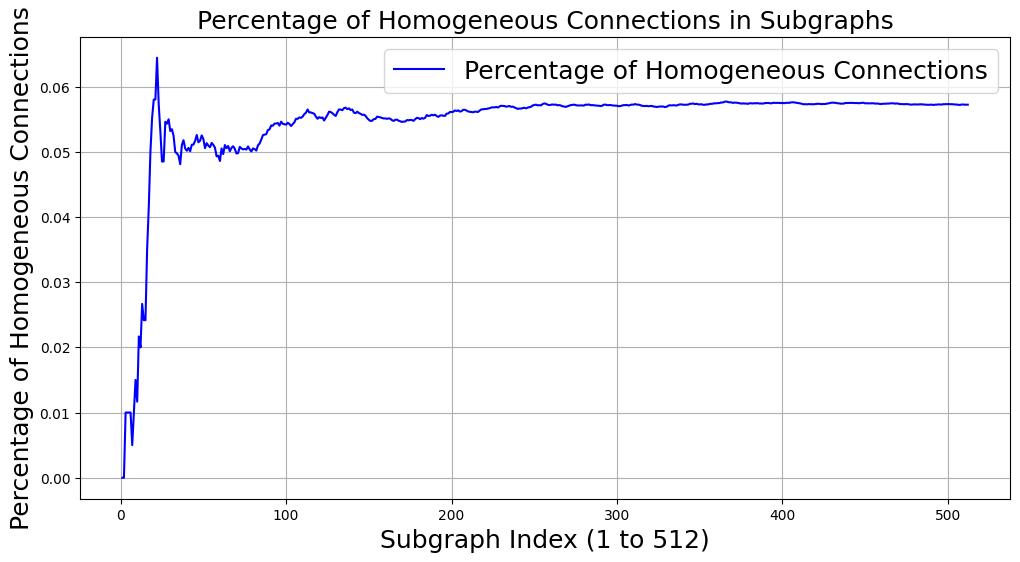

In [79]:
# Visualizing the ratio in a separate graph
plt.figure(figsize=(12, 6))
plt.plot(range(1, ratios.shape[0]+1), ratios, color='blue', label='Percentage of Homogeneous Connections')
plt.title('Percentage of Homogeneous Connections in Subgraphs', fontsize = 18)
plt.xlabel('Subgraph Index (1 to 512)', fontsize = 18)
plt.ylabel('Percentage of Homogeneous Connections', fontsize = 18)
plt.legend(fontsize = 18)
plt.grid(True)
plt.show()

## Combined plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


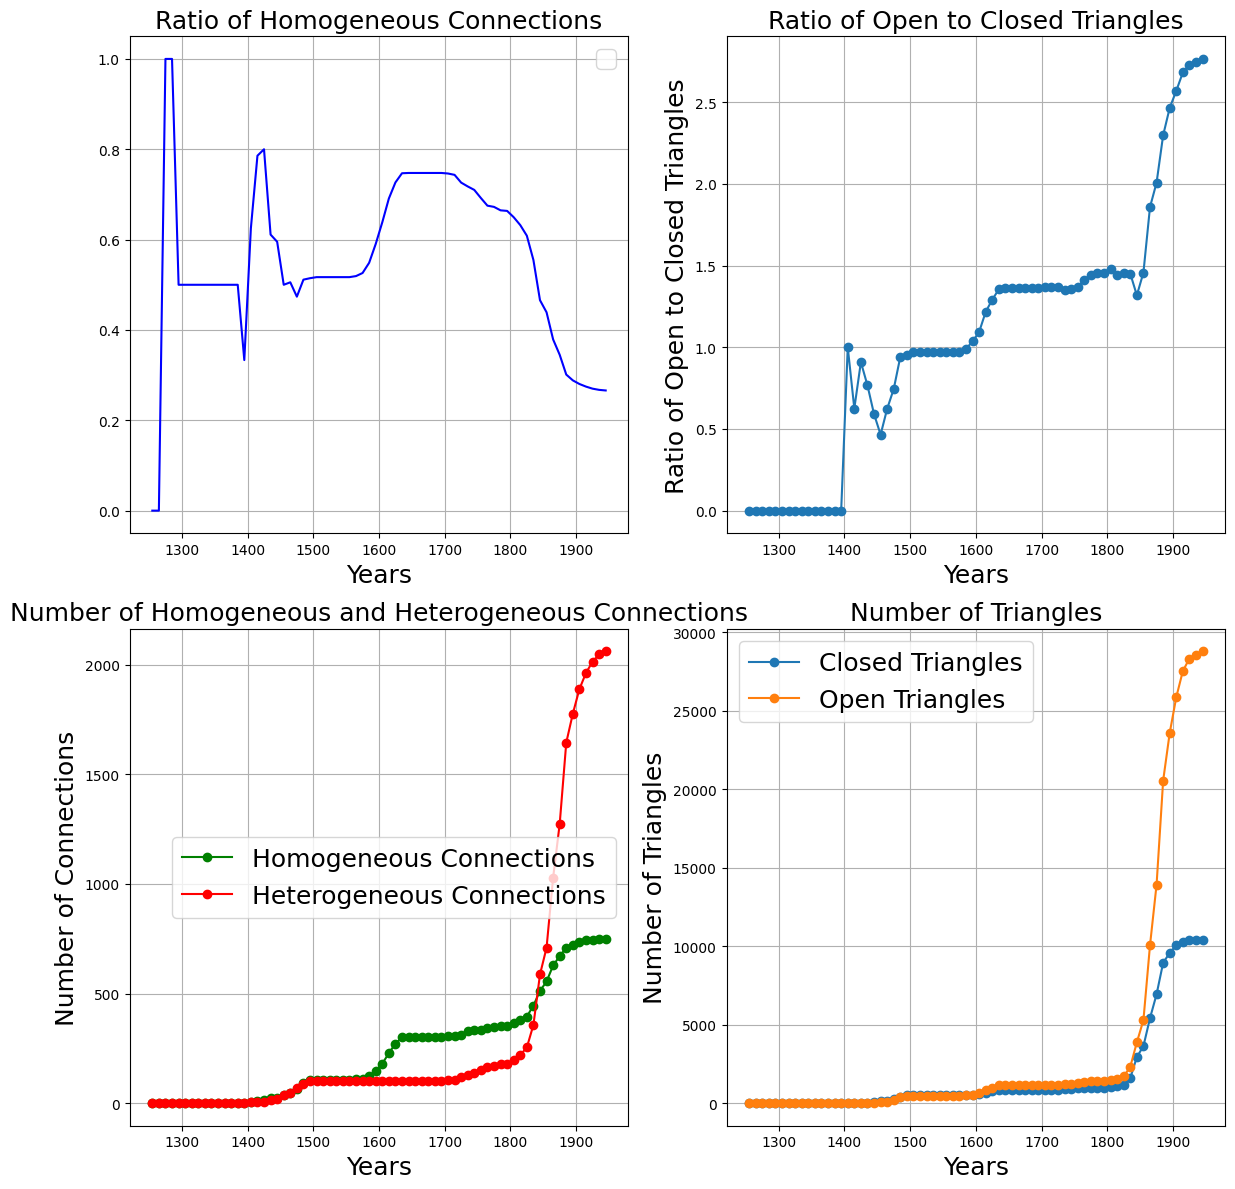

In [50]:
import matplotlib.pyplot as plt

# Assuming you have the data for all the plots

# Visualizing all four plots in one figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plotting the first subplot (Percentage of Homogeneous Connections)
axes[0, 0].plot(range(min_year, max_year+1, 10), good_to_total_ratio, color='blue', )
axes[0, 0].set_title('Ratio of Homogeneous Connections', fontsize=18)
axes[0, 0].set_xlabel('Years', fontsize=18)
axes[0, 0].legend(fontsize=18)
axes[0, 0].grid(True)


# Plotting the second subplot (Ratio of Open to Closed Triangles)
axes[0, 1].plot(range(min_year, max_year+1, 10), ratio_counts, marker='o')
axes[0, 1].set_title('Ratio of Open to Closed Triangles', fontsize=18)
axes[0, 1].set_xlabel('Years', fontsize=18)
axes[0, 1].set_ylabel('Ratio of Open to Closed Triangles', fontsize=18)
axes[0, 1].grid(True)

# Plotting the third subplot (Number of Homogeneous and Heterogeneous Connections)
axes[1, 0].plot(range(min_year, max_year+1, 10), good_connection_counts, marker='o', color='green', label='Homogeneous Connections')
axes[1, 0].plot(range(min_year, max_year+1, 10), bad_connection_counts, marker='o', color='red', label='Heterogeneous Connections')
axes[1, 0].set_title('Number of Homogeneous and Heterogeneous Connections', fontsize=18)
axes[1, 0].set_xlabel('Years', fontsize=18)
axes[1, 0].set_ylabel('Number of Connections', fontsize=18)
axes[1, 0].legend(fontsize=18)
axes[1, 0].grid(True)

# Plotting the fourth subplot (Number of Triangles)
axes[1, 1].plot(range(min_year, max_year+1, 10), closed_triangle_counts, marker='o', label='Closed Triangles')
axes[1, 1].plot(range(min_year, max_year+1, 10), open_triangle_counts, marker='o', label='Open Triangles')
axes[1, 1].set_title('Number of Triangles', fontsize=18)
axes[1, 1].set_xlabel('Years', fontsize=18)
axes[1, 1].set_ylabel('Number of Triangles', fontsize=18)
axes[1, 1].legend(fontsize=18)
axes[1, 1].grid(True)
# Adjust layout to prevent overlapping
plt.tight_layout()
axes[0, 0].set_aspect('auto', adjustable='box')  # Set 1:1 aspect ratio
axes[0, 1].set_aspect('auto', adjustable='box')  # Set 1:1 aspect ratio
axes[1, 0].set_aspect('auto', adjustable='box')  # Set 1:1 aspect ratio
axes[1, 1].set_aspect('auto', adjustable='box')  # Set 1:1 aspect ratio

# Show the combined figure
plt.show()
